In [ ]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.stats as scipy
sys.path.append("..\\backtesting")
import dynamic_backtesting as db
plt.style.use('seaborn')
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=["grey", "green", "black", "deepskyblue", "orange", "lime", "purple", "Gold", "brown", "blue", "pink"]) 

In [ ]:
assets = {"EEM": "Emerging Markets",
           "IVV": "S&P 500",
           "IEV": "MSCI Europe",
           "IXN": "Global Tech",
           "IYR": "US Real Estate",
           "IXG": "Global Financials",
           "EXI": "Global Industrials",
           "GC=F": "Gold Futures", 
           "BZ=F": "Brent Crude Oil Futures",
           "HYG": "High-Yield Corporate Bonds",
           "TLT": "20+ Year Treasury Bonds"}
tickers = list(assets.keys())
asset_names = list(assets.values())
#spx = pd.read_csv('../data/spx.csv').stack().tolist()

**Henter return data udfra tickers**

In [100]:
return_data =db.download_return_data(["IVV","IYR","IXG","GC=F","TLT"], save_to_csv=True)
#laver ny dictionary
included_asset = {asset: assets[asset] for asset in return_data.columns.to_list()}

[*********************100%***********************]  5 of 5 completed


**Henter parametre**

In [ ]:
def GARCH_MODEL(ugarch_model="sGARCH", garch_order=(1, 1)):
    """
    Estimate af GARCH model and parse parameters, sigmas and residuals
    ugarch_model: sGARCH, gjrGARCH
    garch_order: (1, 1), (1,0)
    """
    coef, residuals, sigmas = db.fit_garch_model(ugarch_model=ugarch_model,garch_order=garch_order)
    return coef, residuals, sigmas

**Laver data til IRF plot**

In [193]:
def IRF_maker(GARCHTYPE,t,Asset_number,shock_size, coef, residuals, sigmas):
    """
    Makes data for an IRF plot with a GARCH type model using the data in the csv file and simulation

    Variables:
    t (int): the length of sample
    Asset_number: The asset that receive the shock
    shock_size: the stock to the mean
    GARCHTYPE: sGARCH11, sGARCH10, gjrGARCH11
    Residuals: Past residuals
    Sigmas: Past sigmas
    """
    #unpacks paramters
    params_dict = db.parse_garch_coef(coef, np.shape(residuals)[1], GARCHTYPE)
    mu_T=params_dict["mu"].transpose()
    irf_data=pd.DataFrame(mu_T.repeat(t,axis=0),columns=included_asset)
    #Indsætter chok
    irf_data.iloc[int(t/2),Asset_number]=shock_size
    #udregner omega
    irf_omega_s=db.calc_Omega_ts(irf_data,sigmas,residuals,**params_dict)
    irf_sigma_s=pd.DataFrame([np.diag(Omega) for Omega in irf_omega_s],columns=included_asset)
    irf_sigma_s.index=irf_sigma_s.index-int(t/2)
    #udregner vægte
    irf_weights=pd.DataFrame(db.calc_weights_garch_no_trading_cost(irf_omega_s),columns=included_asset)
    irf_weights.index=irf_weights.index-int(t/2)
    return irf_weights,irf_sigma_s

**Laver figur for ARCH(1)**

In [108]:
coef_ARCH, residuals_ARCH, sigmas_ARCH= GARCH_MODEL("sGARCH",(1,0))

In [194]:
irf_weights_ARCH,irf_sigma_ARCH=IRF_maker("sGARCH10",10000,0,-2,coef_ARCH, residuals_ARCH, sigmas_ARCH)

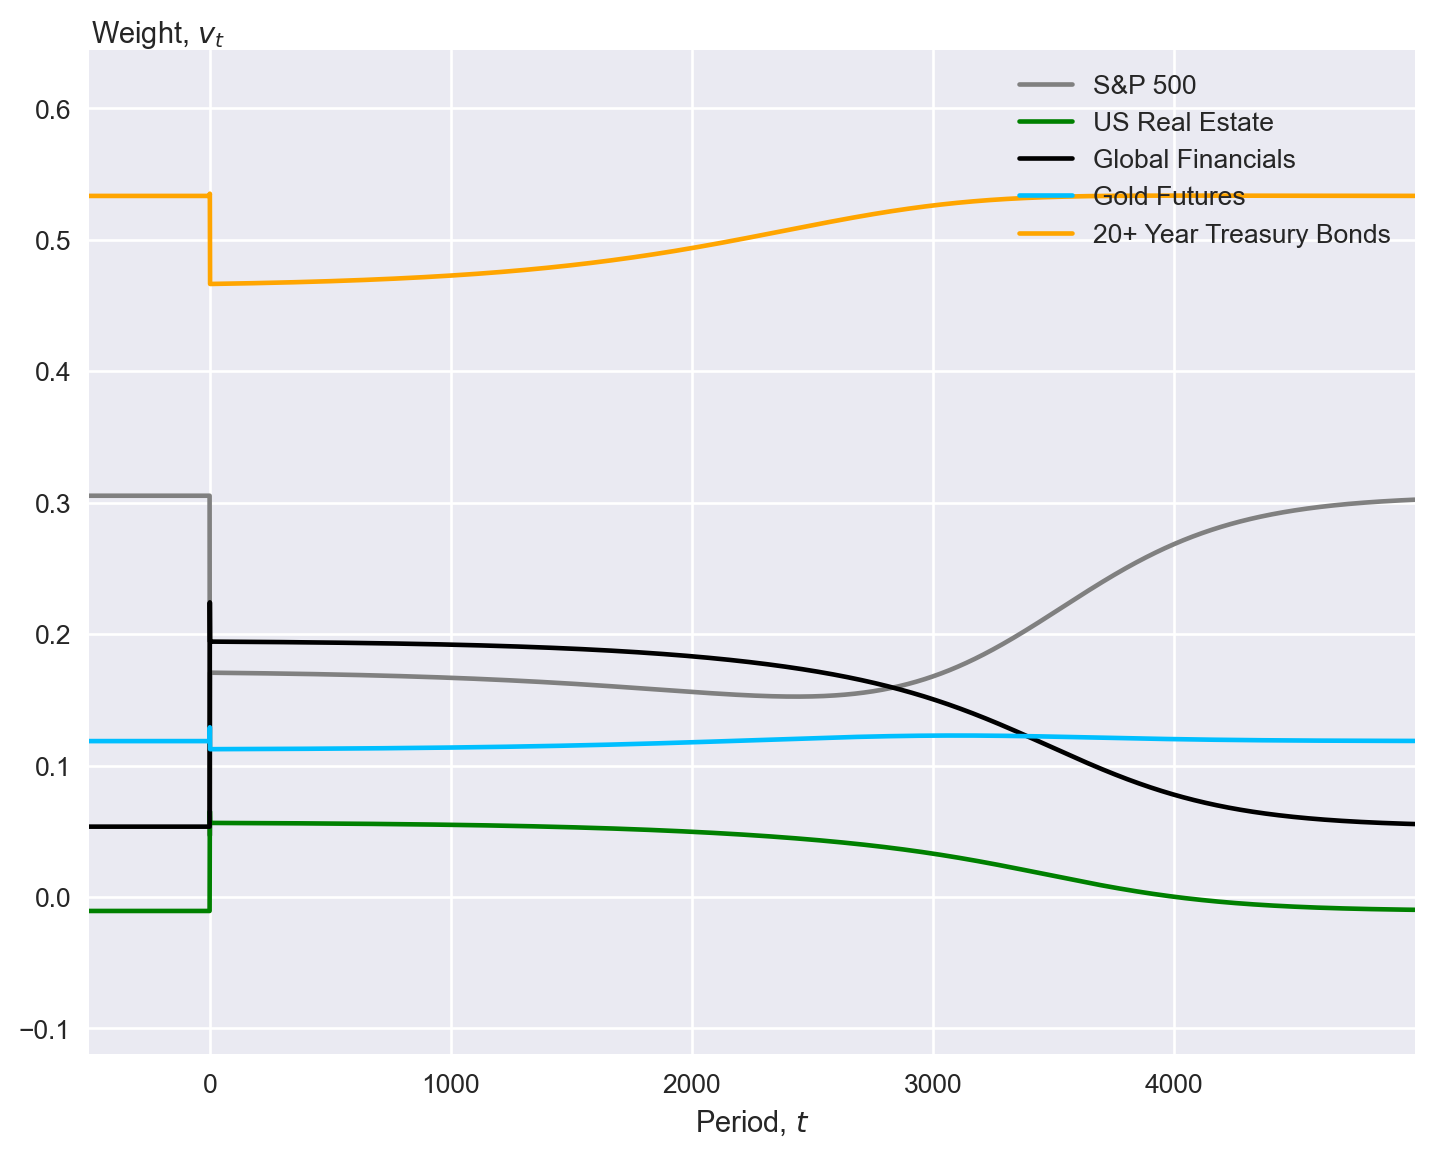

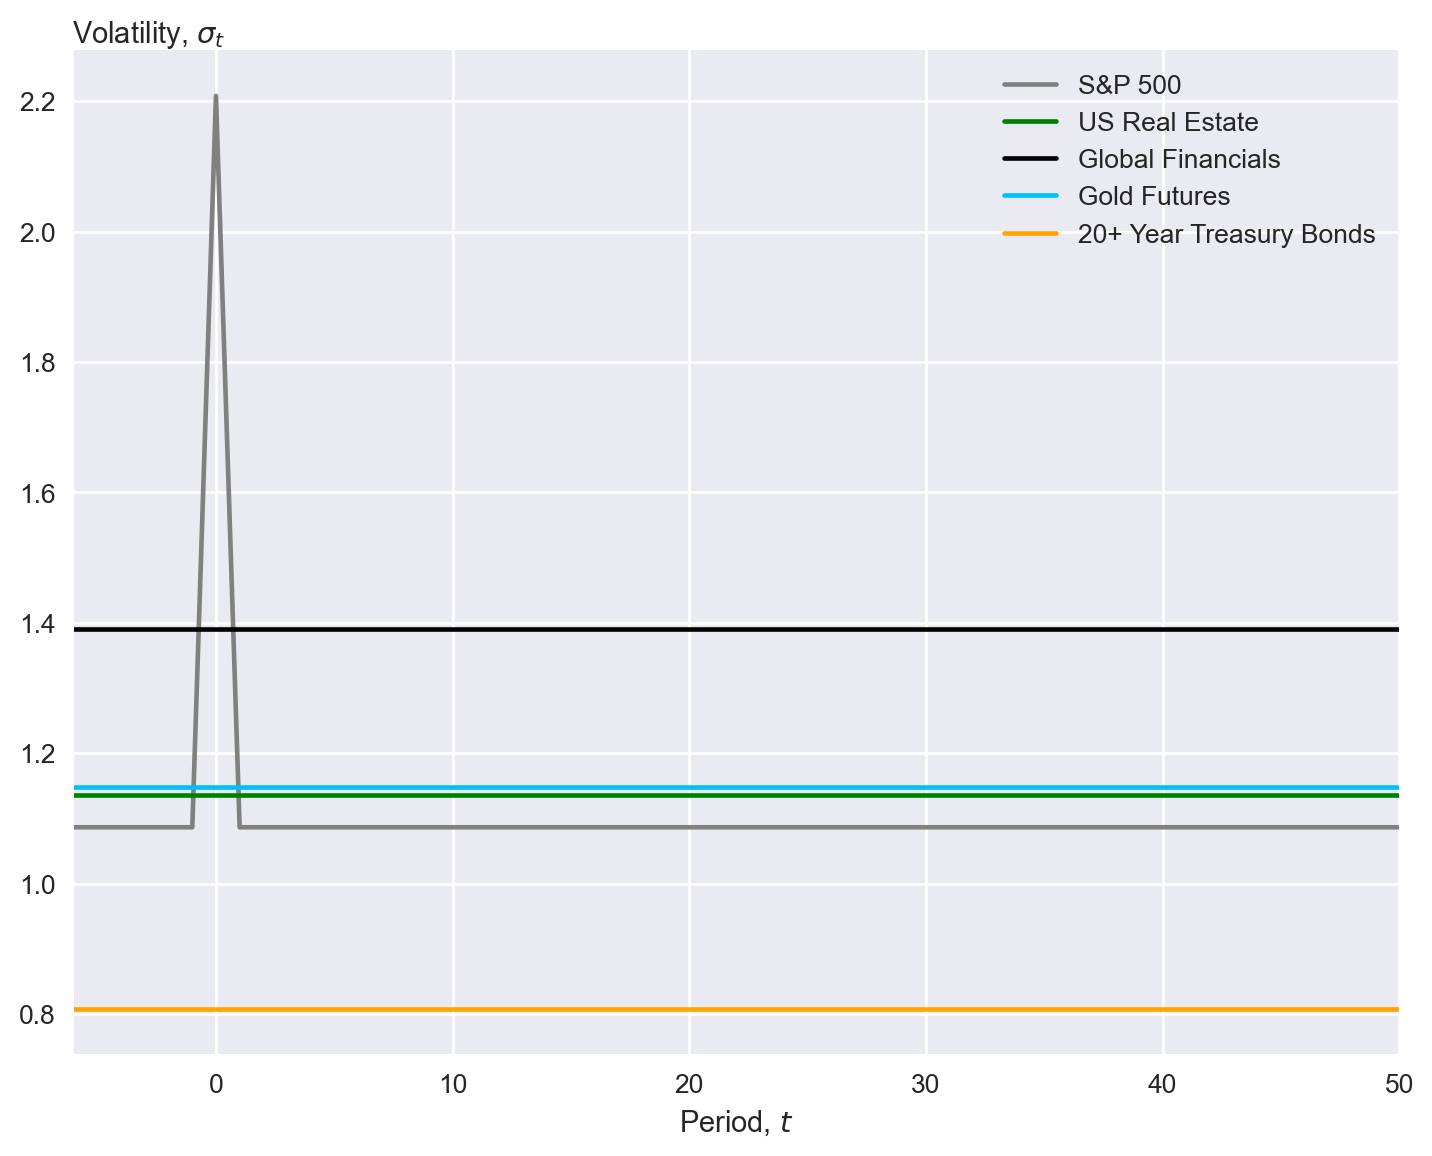

In [213]:
#plt.style.use('seaborn')
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=190)
ax.plot(irf_weights_ARCH)
ax.margins(0,0.2)
ax.set_xlim(-500)
ax.legend(included_asset.values(), loc='upper right')
ax.set_xlabel('Period, $t$') 
ax.set_ylabel('Weight, $v_t$',loc='top', rotation = 0, labelpad = -78) 
fig.savefig("Simulations\IRF_ARCH(1)_weight.png", bbox_inches = 'tight', pad_inches = 0.1)

fig1, ax1 = plt.subplots(1, 1, figsize=(9,7), dpi=190)
ax1.plot(np.sqrt(irf_sigma_ARCH))
ax1.set_xlim(int(0-6),int(0+50))
ax1.legend(included_asset.values(), loc='upper right')
ax1.set_xlabel('Period, $t$') 
ax1.set_ylabel('Volatility, $\sigma_t$',loc='top', rotation = 0, labelpad = -78)
fig1.savefig("Simulations\IRF_ARCH(1)_vol.png", bbox_inches = 'tight', pad_inches = 0.1)

**Laver figur til GARCH(1,1)**

In [173]:
coef_GARCH, residuals_GARCH, sigmas_GARCH= GARCH_MODEL("sGARCH",(1,1))

In [174]:
irf_weights_GARCH,irf_sigma_GARCH=IRF_maker("sGARCH11",10000,0,-2,coef_GARCH, residuals_GARCH, sigmas_GARCH)

0.030570777503143146
0.9557903591478756


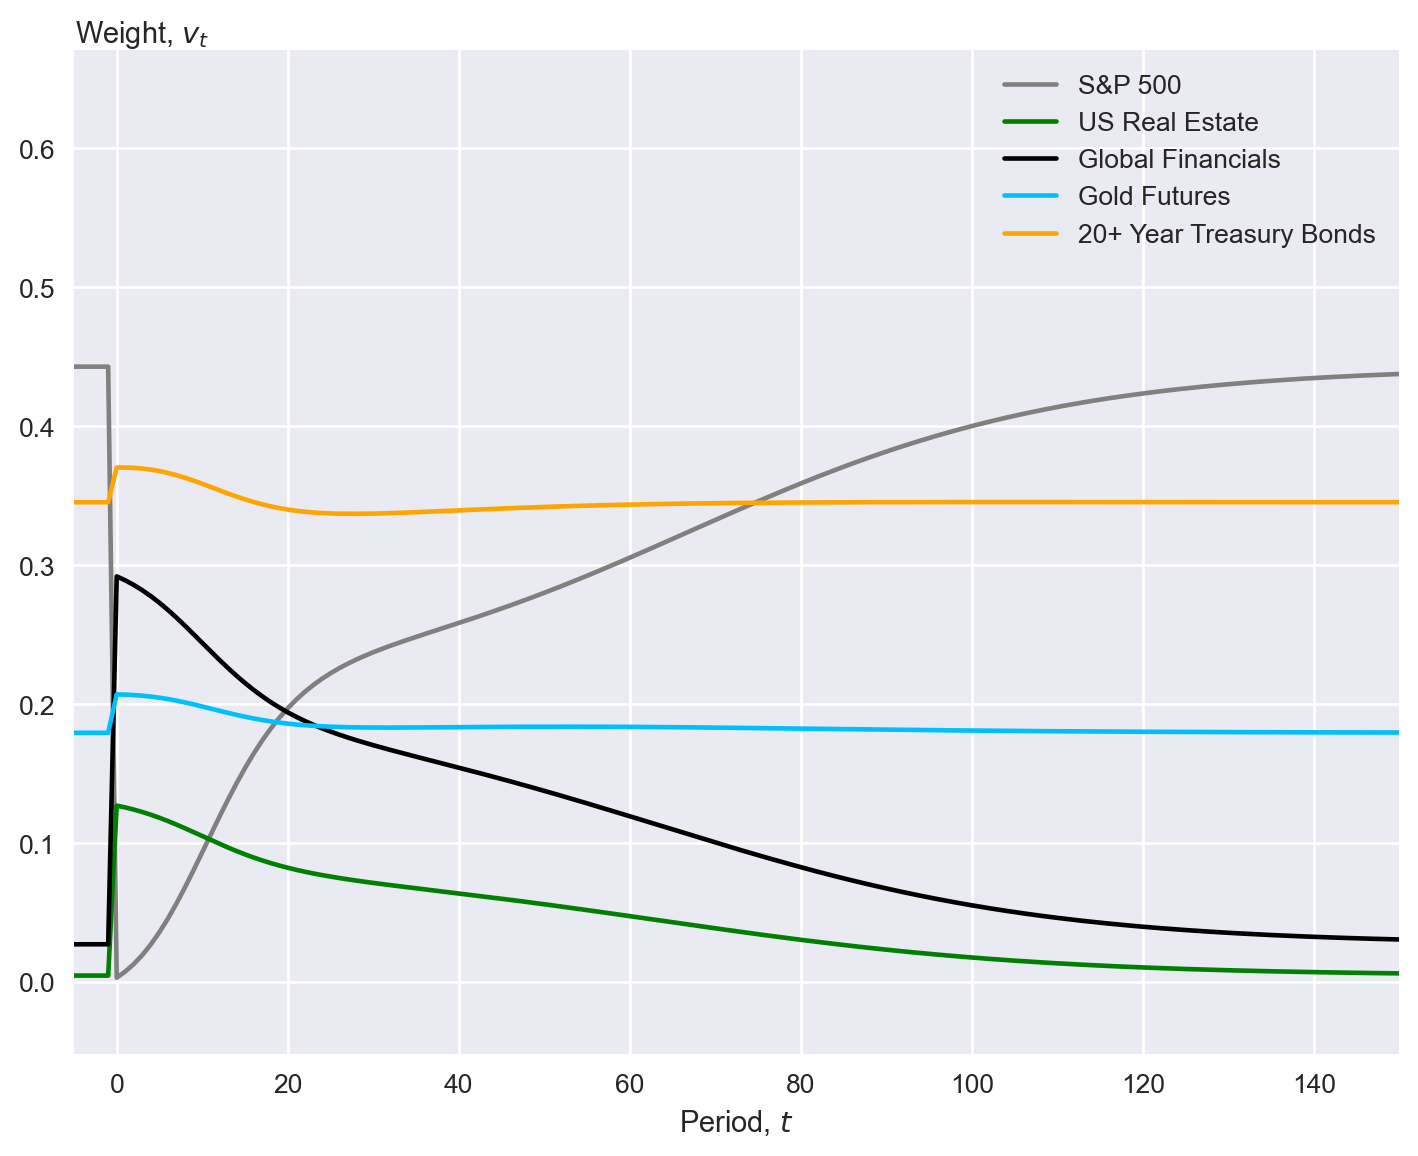

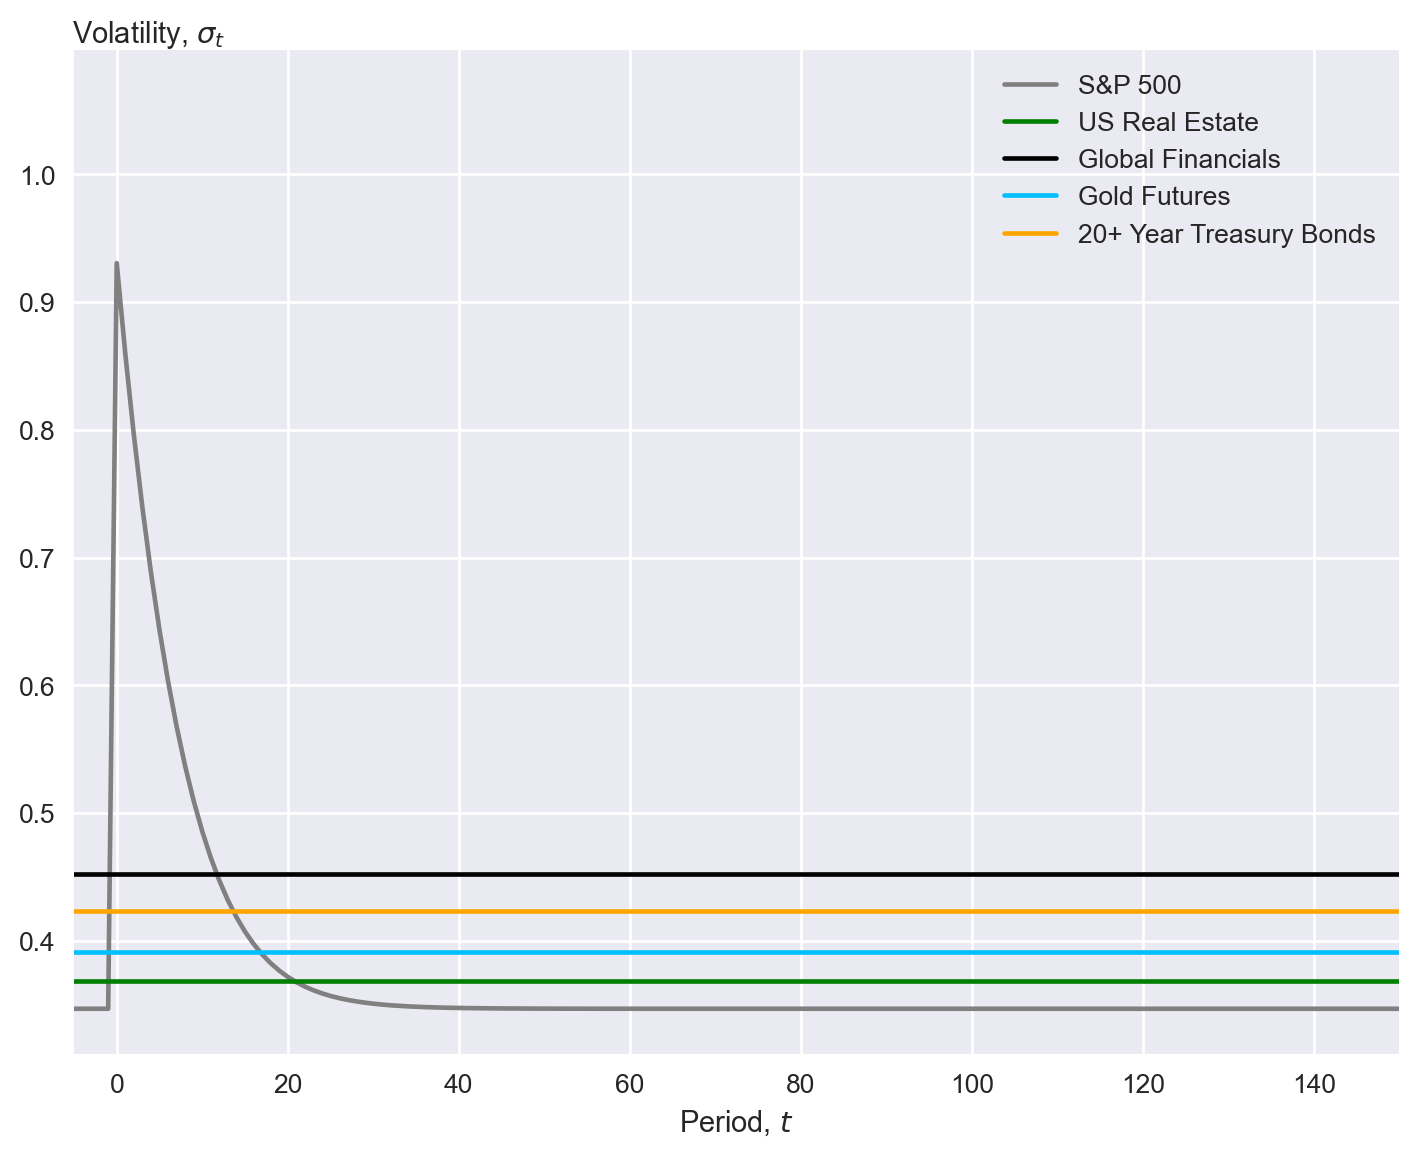

In [212]:
#plt.style.use('seaborn')
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=190)
ax.plot(irf_weights_GARCH)
ax.margins(0,0)
ax.set_xlim(-5,150)
ax.legend(included_asset.values(), loc='upper right')
ax.set_xlabel('Period, $t$') 
ax.set_ylabel('Weight, $v_t$',loc='top', rotation = 0, labelpad = -72) 
fig.savefig("Simulations\IRF_GARCH(1,1)_weight.png", bbox_inches = 'tight', pad_inches = 0.1)

fig1, ax1 = plt.subplots(1, 1, figsize=(9,7), dpi=190)
ax1.plot(np.sqrt(irf_sigma_GARCH))
ax1.set_xlim(-5,150)
ax1.legend(included_asset.values(), loc='upper right')
ax1.set_xlabel('Period, $t$') 
ax1.set_ylabel('Volatility, $\sigma_t$',loc='top', rotation = 0, labelpad = -78) 
fig1.savefig("Simulations\IRF_GARCH(1,1)_vol.png", bbox_inches = 'tight', pad_inches = 0.1)

**Laver figur til GJR-GARCH(1,1)**

In [114]:
coef_GJRGARCH, residuals_GJRGARCH, sigmas_GJRGARCH= GARCH_MODEL("gjrGARCH",(1,1))

In [178]:
irf_weights_GJRGARCH,irf_sigma_GJRGARCH=IRF_maker("gjrGARCH11",10000,0,-2,coef_GJRGARCH, residuals_GJRGARCH, sigmas_GJRGARCH)

0.03307608055376157
0.9497362497094316
gjrGARCH11 detected


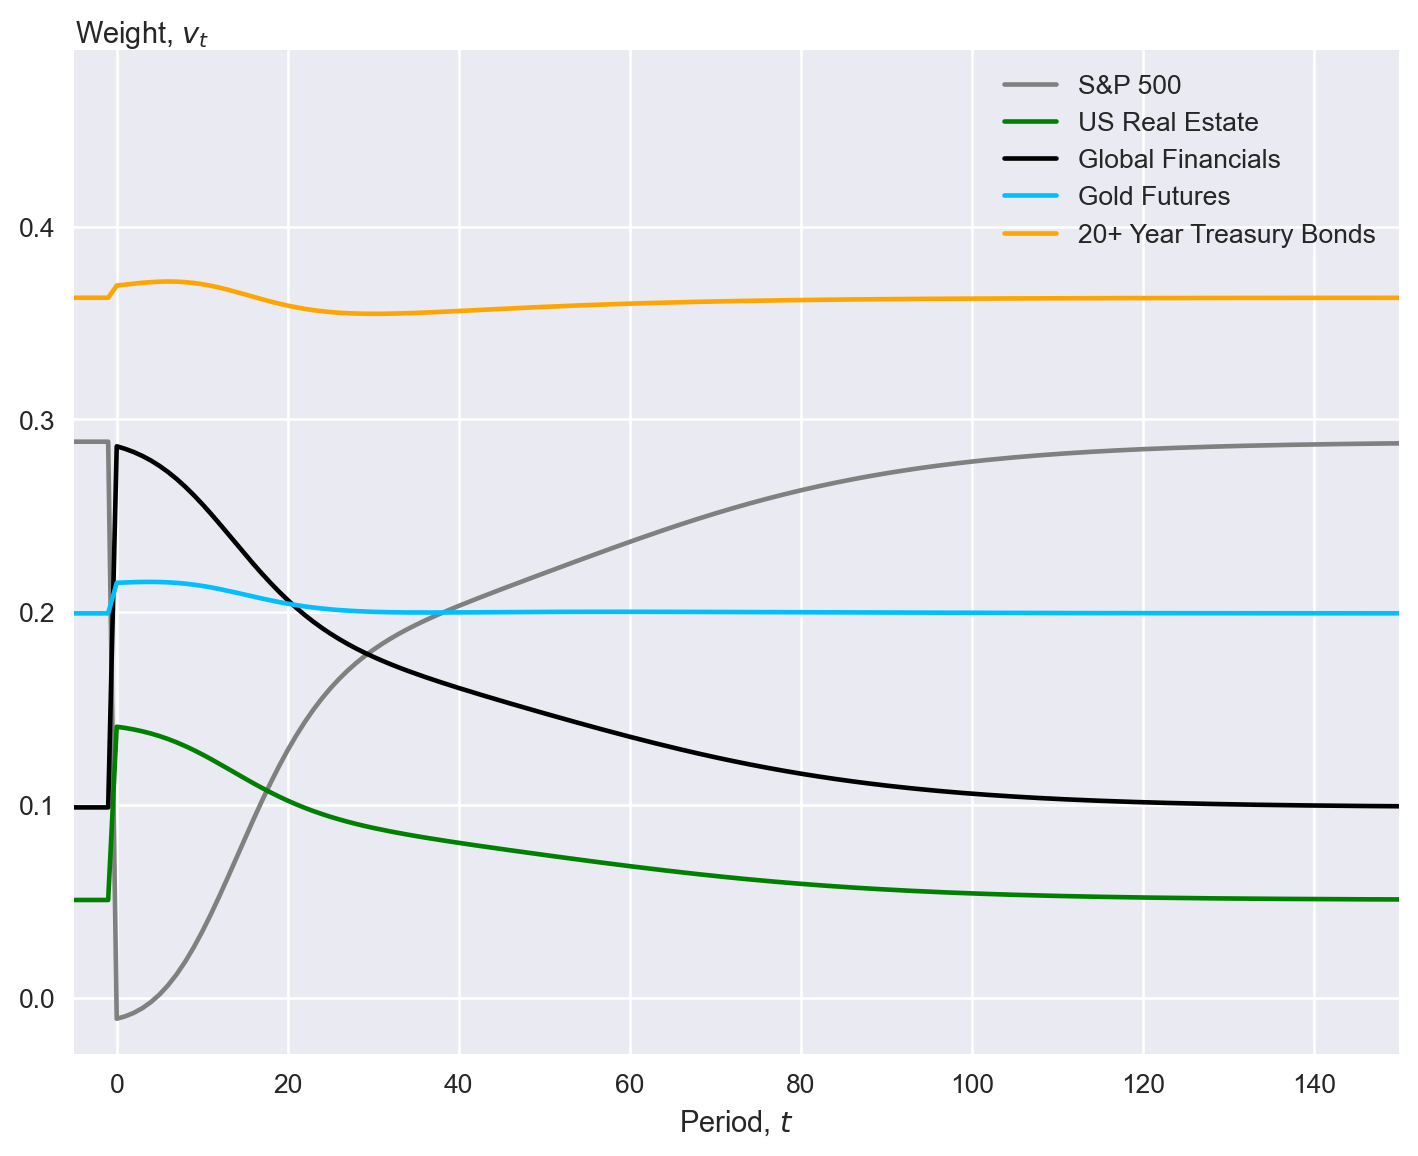

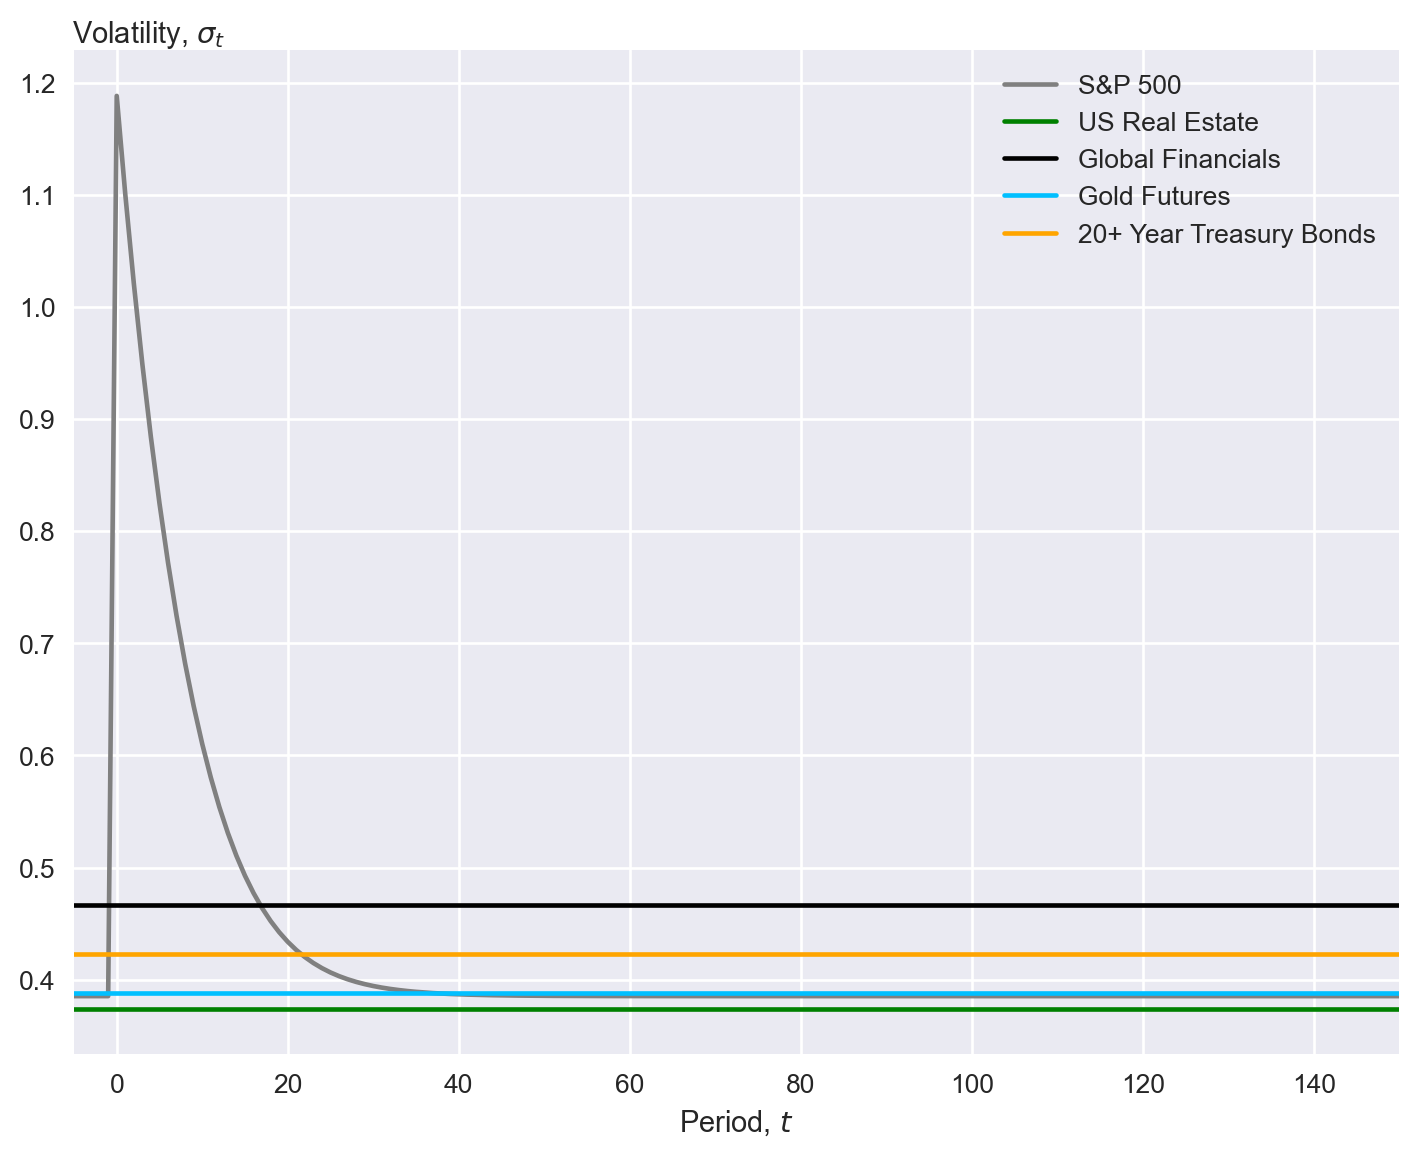

In [208]:
#plt.style.use('seaborn')
fig, ax = plt.subplots(1, 1, figsize=(9,7), dpi=190)
ax.plot(irf_weights_GJRGARCH)
ax.margins(0,0)
ax.set_xlim(-5,150)
ax.legend(included_asset.values(), loc='upper right')
ax.set_xlabel('Period, $t$') 
ax.set_ylabel('Weight, $v_t$',loc='top', rotation = 0, labelpad = -72)
fig.savefig("Simulations\IRF_GJRGARCH(1,1)_vol.png", bbox_inches = 'tight', pad_inches = 0.1)

fig1, ax1 = plt.subplots(1, 1, figsize=(9,7), dpi=190)
ax1.plot(np.sqrt(irf_sigma_GJRGARCH))
ax1.set_xlim(-5,150)
ax1.legend(included_asset.values(), loc='upper right')
ax1.set_xlabel('Period, $t$') 
ax1.set_ylabel('Volatility, $\sigma_t$',loc='top', rotation = 0, labelpad = -78) 
fig1.savefig("Simulations\IRF_GJRGARCH(1,1)_weight.png", bbox_inches = 'tight', pad_inches = 0.1)